In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
%matplotlib inline

#pd.set_option('display.max_colwidth', None)

In [2]:
covid_pos = pd.read_csv("data/COVID_CountByZipPerDate03292021.csv")
covid_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8832 entries, 0 to 8831
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Specimen Collection Date  8832 non-null   object 
 1   Zip                       8456 non-null   float64
 2   Cases                     8832 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 207.1+ KB


In [3]:
covid_pos = covid_pos.rename(columns={'Specimen Collection Date':'Test Date'})
covid_pos.head()

,Test Date,Zip,Cases
0,3/6/2020,37217.0,1
1,3/10/2020,37214.0,1
2,3/11/2020,37013.0,1
3,3/11/2020,37204.0,2
4,3/11/2020,37205.0,1


In [4]:
covid_vacc = pd.read_csv("data/vaccine_with_protocol.csv")
covid_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vacc_date    6694 non-null   object 
 1   zipcode      6462 non-null   float64
 2   count_given  6686 non-null   float64
 3   dose_nbr     6686 non-null   float64
 4   protocol     6694 non-null   object 
dtypes: float64(3), object(2)
memory usage: 261.6+ KB


In [5]:
#rename zipcode column to zip & verify/check null values
covid_vacc = covid_vacc.rename(columns={'zipcode':'zip'})
covid_vacc.head()
#covid_vacc.isnull().sum()


,vacc_date,zip,count_given,dose_nbr,protocol
0,2020-12-12,37215.0,1.0,1.0,two-shot
1,2020-12-14,37205.0,1.0,2.0,two-shot
2,2020-12-14,37215.0,1.0,1.0,two-shot
3,2020-12-15,37221.0,1.0,1.0,two-shot
4,2020-12-16,37215.0,1.0,1.0,two-shot


In [6]:
#group vaccinations by zip code
covid_vacc_per_zip = covid_vacc.groupby('zip')['count_given'].sum().reset_index()
covid_vacc_per_zip.head()
#covid_vacc_per_zip.shape

,zip,count_given
0,37013.0,27167.0
1,37027.0,506.0
2,37069.0,89.0
3,37072.0,13108.0
4,37076.0,16855.0


In [7]:
#what happened to the nulls in zips in original dataframe?
covid_vacc_per_zip.isnull().sum()

zip            0
count_given    0
dtype: int64

In [8]:
zipcodes = gpd.read_file("data/zipcodes.geojson")
zipcodes.head()

,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


In [9]:
zipcodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   zip             56 non-null     object  
 1   objectid        56 non-null     object  
 2   po_name         56 non-null     object  
 3   shape_stlength  56 non-null     object  
 4   shape_starea    56 non-null     object  
 5   geometry        56 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 2.8+ KB


In [10]:
#cast zipcode as float in zipcodes
zipcodes['zip'] = zipcodes['zip'].astype('float')
zipcodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   zip             56 non-null     float64 
 1   objectid        56 non-null     object  
 2   po_name         56 non-null     object  
 3   shape_stlength  56 non-null     object  
 4   shape_starea    56 non-null     object  
 5   geometry        56 non-null     geometry
dtypes: float64(1), geometry(1), object(4)
memory usage: 2.8+ KB


In [11]:
pop_by_zip = pd.read_csv("data/zipcode population.csv")
pop_by_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   number    610 non-null    int64 
 1   zip       610 non-null    int64 
 2   lat,long  610 non-null    object
 3   city      610 non-null    object
 4   pop       610 non-null    object
dtypes: int64(2), object(3)
memory usage: 24.0+ KB


In [36]:
pop_by_zip['pop'] = (pop_by_zip['pop'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
pop_by_zip['pop'] = pop_by_zip['pop'].astype('float')
pop_by_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   number    610 non-null    int64  
 1   zip       610 non-null    int64  
 2   lat,long  610 non-null    object 
 3   city      610 non-null    object 
 4   pop       610 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 24.0+ KB


In [37]:
pop_by_zip.head()

,number,zip,"lat,long",city,pop
0,1,37916,"35.953657, -83.933148","Knoxville, Tennessee",11672.0
1,2,37614,"36.301650, -82.370809","Johnson City, Tennessee",2036.0
2,3,37212,"36.133973, -86.801471","Nashville, Tennessee",18547.0
3,4,37351,"35.104194, -85.264615","Lupton City, Tennessee",270.0
4,5,37744,"36.182885, -82.740218","Greeneville, Tennessee",372.0


In [38]:
#Combine zipcodes geodataframe with vaccincation dataframe to make choropleth plot
#Using left merge to also see zips without vaccines or without reports of them
#drop duplicate zips

geo_vaccine = zipcodes.merge(covid_vacc_per_zip, on = 'zip', how='left')
geo_vaccine = geo_vaccine.sort_values('count_given',ascending=False).reset_index()
geo_vaccine = geo_vaccine.drop_duplicates('zip')
geo_vaccine

,index,zip,objectid,po_name,shape_stlength,shape_starea,geometry,count_given
0,49,37211.0,39,NASHVILLE,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",28477.0
1,7,37221.0,17,NASHVILLE,241372.3112694624,1266395059.4877319,"MULTIPOLYGON (((-86.97084 36.11644, -86.97084 ...",27622.0
2,51,37013.0,34,ANTIOCH,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",27167.0
3,32,37205.0,16,NASHVILLE,146801.80831498865,400978073.00933838,"MULTIPOLYGON (((-86.81907 36.13351, -86.81688 ...",24451.0
4,12,37209.0,10,NASHVILLE,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",20553.0
5,44,37215.0,38,NASHVILLE,158698.30754566603,424774478.15600586,"MULTIPOLYGON (((-86.81428 36.12618, -86.81425 ...",19915.0
6,28,37076.0,52,HERMITAGE,3786.7098050626546,675823.34777832031,"MULTIPOLYGON (((-86.52159 36.13816, -86.52174 ...",16855.0
8,13,37206.0,2,NASHVILLE,75782.862116030214,221537063.58166504,"MULTIPOLYGON (((-86.75348 36.16274, -86.75383 ...",14310.0
9,19,37207.0,49,NASHVILLE,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",13888.0
11,37,37214.0,6,NASHVILLE,165410.80552044208,674068994.30090332,"MULTIPOLYGON (((-86.65585 36.11824, -86.66410 ...",13573.0


In [39]:
geo_vaccine.shape

(38, 8)

In [40]:
geo_vaccine.isnull().sum()
#what happened to the null zips in covid_vacc?

index             0
zip               0
objectid          0
po_name           0
shape_stlength    0
shape_starea      0
geometry          0
count_given       9
dtype: int64

In [45]:
geo_vaccine_pop = geo_vaccine.merge(pop_by_zip, on = 'zip', how='inner')
geo_vaccine_pop = geo_vaccine_pop.drop(columns=['index','objectid','number','lat,long', 'city']).reset_index()
geo_vaccine_pop['percent_vaxxed'] = round((geo_vaccine_pop['count_given']/geo_vaccine_pop['pop']),2)
geo_vaccine_pop

,index,zip,po_name,shape_stlength,shape_starea,geometry,count_given,pop,percent_vaxxed
0,0,37211.0,NASHVILLE,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",28477.0,64753.0,0.44
1,1,37221.0,NASHVILLE,241372.3112694624,1266395059.4877319,"MULTIPOLYGON (((-86.97084 36.11644, -86.97084 ...",27622.0,34809.0,0.79
2,2,37013.0,ANTIOCH,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",27167.0,51343.0,0.53
3,3,37205.0,NASHVILLE,146801.80831498865,400978073.00933838,"MULTIPOLYGON (((-86.81907 36.13351, -86.81688 ...",24451.0,21861.0,1.12
4,4,37209.0,NASHVILLE,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",20553.0,35081.0,0.59
5,5,37215.0,NASHVILLE,158698.30754566603,424774478.15600586,"MULTIPOLYGON (((-86.81428 36.12618, -86.81425 ...",19915.0,22112.0,0.90
6,6,37076.0,HERMITAGE,3786.7098050626546,675823.34777832031,"MULTIPOLYGON (((-86.52159 36.13816, -86.52174 ...",16855.0,29547.0,0.57
7,7,37206.0,NASHVILLE,75782.862116030214,221537063.58166504,"MULTIPOLYGON (((-86.75348 36.16274, -86.75383 ...",14310.0,27751.0,0.52
8,8,37207.0,NASHVILLE,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",13888.0,35744.0,0.39
9,9,37214.0,NASHVILLE,165410.80552044208,674068994.30090332,"MULTIPOLYGON (((-86.65585 36.11824, -86.66410 ...",13573.0,26474.0,0.51


In [46]:
geo_vaccine_pop.shape
#lost two rows after merging population data?

(36, 9)

In [48]:
#remove weird outlier (300%, row 24)
geo_vaccine_pop = geo_vaccine_pop.drop([24,25])
geo_vaccine_pop

,index,zip,po_name,shape_stlength,shape_starea,geometry,count_given,pop,percent_vaxxed
0,0,37211.0,NASHVILLE,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",28477.0,64753.0,0.44
1,1,37221.0,NASHVILLE,241372.3112694624,1266395059.4877319,"MULTIPOLYGON (((-86.97084 36.11644, -86.97084 ...",27622.0,34809.0,0.79
2,2,37013.0,ANTIOCH,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",27167.0,51343.0,0.53
3,3,37205.0,NASHVILLE,146801.80831498865,400978073.00933838,"MULTIPOLYGON (((-86.81907 36.13351, -86.81688 ...",24451.0,21861.0,1.12
4,4,37209.0,NASHVILLE,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",20553.0,35081.0,0.59
5,5,37215.0,NASHVILLE,158698.30754566603,424774478.15600586,"MULTIPOLYGON (((-86.81428 36.12618, -86.81425 ...",19915.0,22112.0,0.90
6,6,37076.0,HERMITAGE,3786.7098050626546,675823.34777832031,"MULTIPOLYGON (((-86.52159 36.13816, -86.52174 ...",16855.0,29547.0,0.57
7,7,37206.0,NASHVILLE,75782.862116030214,221537063.58166504,"MULTIPOLYGON (((-86.75348 36.16274, -86.75383 ...",14310.0,27751.0,0.52
8,8,37207.0,NASHVILLE,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",13888.0,35744.0,0.39
9,9,37214.0,NASHVILLE,165410.80552044208,674068994.30090332,"MULTIPOLYGON (((-86.65585 36.11824, -86.66410 ...",13573.0,26474.0,0.51


Text(0.5, 1.0, 'Vaccine Rates by Zipcode')

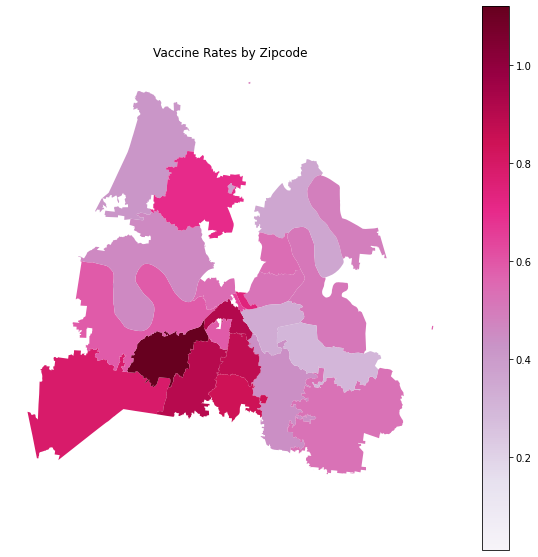

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
geo_vaccine_pop.plot(ax=ax, column = 'percent_vaxxed', cmap = 'PuRd', legend = True)
ax.axis('off')
plt.title('Vaccine Rates by Zipcode')

In [ ]:
# Do I really need this to be here? Do we need interactivity?

# vacc_map = folium.Map(location = (36.174465, -86.767960), zoom_start = 10)
# folium.GeoJson(geo_vaccine).add_to(vacc_map)
# vacc_map